In [4]:
#easy data collection
#just name class then capture using phone to auto-create folder with images
#install app like ip webcam on phone

import cv2
import os

cls = "0"
path = fr'C:\Users\x\Documents\capstone\cnn\{cls}'
os.makedirs(path, exist_ok=True)

#phone ip
url = "http://192.168.1.213:8080/video"
cap = cv2.VideoCapture(url)

count = len(os.listdir(path))

print("space to capture\n'q' to quit.")

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    img = cv2.resize(img, (640, 480))
    cv2.imshow("Feed", img)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break

    if key == 32:
        cv2.imwrite(os.path.join(path, f"{cls}_{count}.jpg"), img)
        count += 1

cap.release()
cv2.destroyAllWindows()


space to capture
'q' to quit.


Epoch 1/100
Train Loss: 2.4323, Validation Loss: 1.6035, Accuracy: 48.31%
Epoch 2/100
Train Loss: 1.2196, Validation Loss: 0.6875, Accuracy: 75.42%
Epoch 3/100
Train Loss: 0.7884, Validation Loss: 0.4380, Accuracy: 85.59%
Epoch 4/100
Train Loss: 0.6011, Validation Loss: 0.3805, Accuracy: 88.14%
Epoch 5/100
Train Loss: 0.4837, Validation Loss: 0.2929, Accuracy: 88.14%
Epoch 6/100
Train Loss: 0.4382, Validation Loss: 0.2902, Accuracy: 88.14%
Epoch 7/100
Train Loss: 0.3318, Validation Loss: 0.2728, Accuracy: 87.29%
Epoch 8/100
Train Loss: 0.3331, Validation Loss: 0.3111, Accuracy: 86.44%
Epoch 9/100
Train Loss: 0.2984, Validation Loss: 0.2142, Accuracy: 91.53%
Epoch 10/100
Train Loss: 0.2853, Validation Loss: 0.2477, Accuracy: 89.83%
Epoch 11/100
Train Loss: 0.2449, Validation Loss: 0.1817, Accuracy: 91.53%
Epoch 12/100
Train Loss: 0.2327, Validation Loss: 0.1878, Accuracy: 90.68%
Epoch 13/100
Train Loss: 0.1997, Validation Loss: 0.1739, Accuracy: 92.37%
Epoch 14/100
Train Loss: 0.1769, V

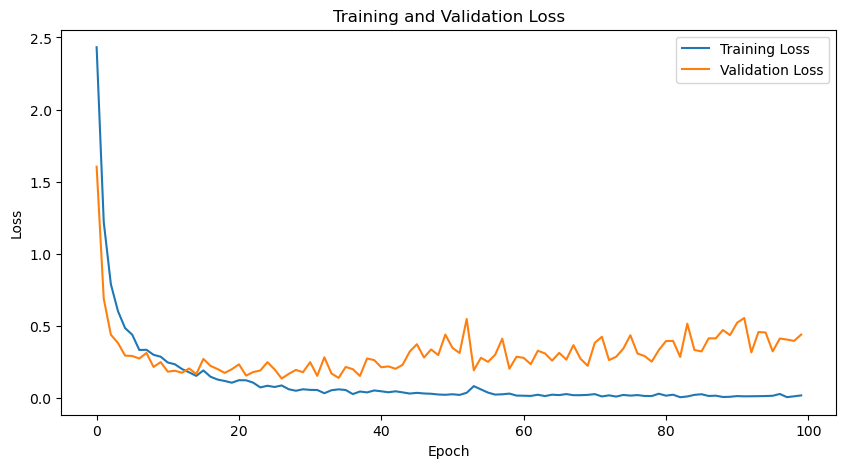

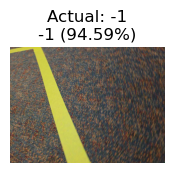

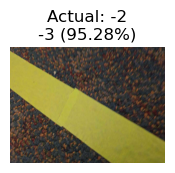

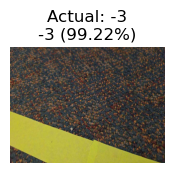

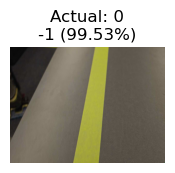

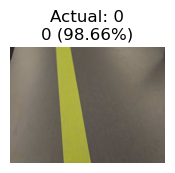

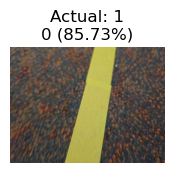

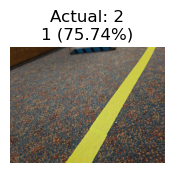

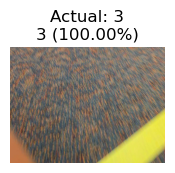

In [12]:
#train and test

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

name = "lines"
data_dir = fr'C:\Users\x\Documents\capstone\cnn\{name}\imgs-data'
test_dir = fr'C:\Users\x\Documents\capstone\cnn\{name}\imgs-test'
model_save_path = fr'C:\Users\x\Documents\capstone\cnn\{name}.pth'

transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

all_data = datasets.ImageFolder(data_dir, transform=transform)
class_names = all_data.classes
classes = len(class_names)

train_ratio = 0.8
train_size = int(train_ratio * len(all_data))
test_size = len(all_data) - train_size
train_data, test_data = random_split(all_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 60 * 60, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 60 * 60)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []


def train(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)


def test(model, loader, device):
    model.eval()
    total, correct = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy, running_loss / len(loader)

epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    val_accuracy, val_loss = test(model, test_loader, device)
    val_losses.append(val_loss)
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

def display_predictions(image_path, model, class_names, actual_class=None):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0]
        predicted_index = torch.argmax(probabilities).item()
        predicted_class = class_names[predicted_index]
        confidence = probabilities[predicted_index].item() * 100
    text = f"{predicted_class} ({confidence:.2f}%)"
    if actual_class:
        text = f"Actual: {actual_class}\n" + text
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')
    plt.title(text)
    plt.show()

if os.path.exists(test_dir):
    for class_folder in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_folder)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                display_predictions(image_path, model, class_names, actual_class=class_folder)


In [10]:
#realtime testing using phone camera

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from PIL import Image
from torchvision import datasets, transforms

#phone ip
url = "http://192.168.1.213:8080/video"
name = "lines"
model_save_path = fr'C:\Users\x\Documents\capstone\cnn\{name}.pth'
data_dir = fr'C:\Users\x\Documents\capstone\cnn\{name}\imgs-data'


transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 60 * 60, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 60 * 60)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


all_data = datasets.ImageFolder(data_dir, transform=transform)
class_names = all_data.classes
classes = len(class_names)
model = CNN(num_classes=classes)

checkpoint = torch.load(model_save_path, map_location=device)
model.fc2 = nn.Linear(128, checkpoint["fc2.weight"].size(0))  
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

def predict_from_webcam(frame, model, class_names, transform, device):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)[0]
        predicted_index = probabilities.argmax().item()
        predicted_class = class_names[predicted_index]
        confidence = probabilities[predicted_index].item() * 100
    return predicted_class, confidence

cap = cv2.VideoCapture(url)

print("Starting webcam. Press 'q' to quit.")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))
    predicted_class, confidence = predict_from_webcam(frame, model, class_names, transform, device)

    text = f"{predicted_class}: {confidence:.2f}%"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Webcam Predictions", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\x\AppData\Local\Temp\ipykernel_38872\3297881467.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path, map_location=device)


Starting webcam. Press 'q' to quit.
